STEP 0. Import data from finnhub

In [ ]:
pip install finnhub-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import finnhub
import datetime
finnhub_client = finnhub.Client(api_key="cfgveo1r01qlga2um3tgcfgveo1r01qlga2um3u0")
data = finnhub_client.stock_candles('TSLA', 'D', 1325307600, 1676670749)
df = pd.DataFrame(data)
df = df.drop('s', axis=1)
df = df.rename(columns={'c': 'Close','h':'High','l':'Low','o':"Open",'t':"TimeStamp",'v':'Volume'})
df['Date'] = pd.to_datetime(df['TimeStamp'], unit='s')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Close,High,Low,Open,TimeStamp,Volume
Date,,,,,,
2012-01-03,1.872000,1.966660,1.843327,1.929327,1325548800,13920780
2012-01-04,1.847327,1.911333,1.833327,1.880660,1325635200,9450540
2012-01-05,1.808000,1.862000,1.790000,1.850660,1325721600,15081495
2012-01-06,1.794000,1.852660,1.760660,1.813333,1325808000,14794305
2012-01-09,1.816660,1.832660,1.741327,1.800000,1326067200,13454265
...,...,...,...,...,...,...
2023-02-13,194.640000,196.300000,187.610000,194.415000,1676246400,172475452
2023-02-14,209.250000,209.820000,189.440000,191.940000,1676332800,216455708
2023-02-15,214.240000,214.660000,206.110000,211.755000,1676419200,182108581


STEP 1. Calculate and plot the daily returns

In [ ]:
df['Return'] = 100*(df['Close'].pct_change())
df.head()

,Close,High,Low,Open,TimeStamp,Volume,Return
Date,,,,,,,
2012-01-03,1.872000,1.966660,1.843327,1.929327,1325548800,13920780,NaN
2012-01-04,1.847327,1.911333,1.833327,1.880660,1325635200,9450540,-1.318020
2012-01-05,1.808000,1.862000,1.790000,1.850660,1325721600,15081495,-2.128842
2012-01-06,1.794000,1.852660,1.760660,1.813333,1325808000,14794305,-0.774336
2012-01-09,1.816660,1.832660,1.741327,1.800000,1326067200,13454265,1.263099


Text(0.5, 1.0, 'Daily Returns Over Time')

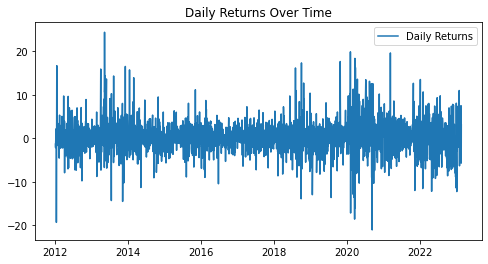

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

step 2: calculate daily, monthly and annual volatility

In [ ]:
# daily volatility
daily_volatility = df['Return'].std()

# monthly volatility
monthly_volatility = math.sqrt(21) * daily_volatility

# annual volatility
annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))


╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         3.60         │         16.51          │         57.18         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


step 3: build DTW model

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks

In [ ]:
def dtw(x, y):
    """
    Compute the Dynamic Time Warping (DTW) distance between two time series.
    :param x: numpy array containing the first time series
    :param y: numpy array containing the second time series
    :return: the DTW distance between x and y
    IMPORTANT: x, y should be in the same length.
    """
    n = len(x)
    m = len(y)
    DTW = np.zeros((n + 1, m + 1))

    for i in range(n+1):
        for j in range(m+1):
            DTW[i, j] = np.inf
    DTW[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(x[i - 1] - y[j - 1])
            DTW[i, j] = cost + min(DTW[i - 1, j], DTW[i, j - 1], DTW[i - 1, j - 1])

    return DTW[n, m]


In [ ]:
#testing dtw
daily_return = np.array(df['Return'])
daily_return1 = daily_return[0:10]
daily_return2 = daily_return[10:20]
dtw(daily_return1, daily_return2)

41.035478294899285

In [ ]:
def find_similar_pattern(query, dataset, threshold=0.1):
    """
    Find the patterns in the dataset that are similar to the query pattern using Dynamic Time Warping (DTW).
    :param query: numpy array containing the query pattern
    :param dataset: numpy array containing the dataset of patterns
    :param threshold: threshold value for DTW distance
    :return: list of indices of the patterns in the dataset that are similar to the query pattern
    """
    similar_patterns = []
    for i, pattern in enumerate(dataset):
        if len(query) != len(pattern):
            continue
        dist = dtw(query, pattern)
        if dist < threshold:
            similar_patterns.append(i)

    return similar_patterns

In [ ]:
#test fsp
find_similar_pattern(daily_return1,daily_return)

TypeError: ignored

In [ ]:
pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-linux_x86_64.whl size=534332 sha256=21ef8ab2f4d4ada86b4c763f5d14b397c3095e739c6b6678e25b453f71e90857
  Stored in directory: /root/.cache/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def find_similar_pattern(target, candidates):
    """
    Finds an array with a similar pattern to the target array using DTW.
    """
    best_candidate = None
    best_distance = np.inf
    for candidate in candidates:
        distance, _ = fastdtw(target, candidate, dist=euclidean)
        if distance < best_distance:
            best_candidate = candidate
            best_distance = distance
    return best_candidate

In [ ]:
target = np.array([1, 2, 3, 2, 1])
candidates = np.array([0, 1, 2, 1, 0])
similar_pattern = find_similar_pattern(target, candidates)
print(similar_pattern)

TypeError: ignored